In [1]:
%pip install surprise
%pip install missingno

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [28]:
%pip install -q tensorflow-recommenders
%pip install -q --upgrade tensorflow-datasets
%pip install -q scann

^C
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
from surprise import SVD,Reader,Dataset
from surprise.model_selection import cross_validate

## Open and view the dataset


In [4]:
data = pd.read_csv("ratings_Electronics (1).csv")
data

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600
...,...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0,1396569600
7824477,A322MDK0M89RHN,BT008UKTMW,5.0,1313366400
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0,1404172800
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0,1297555200


In [6]:
# Let's rename the columns 
column_names = ( "userId", "productId", "rating", "timestamp")
data.columns = column_names
data.head()

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


The data is a lot we should take a sample of about 20000 entries

In [7]:
sampled_data = data.sample(n=20000)
sampled_data.shape

(20000, 4)

## Explore the data frame

In [8]:
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 4772233 to 3144565
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     20000 non-null  object 
 1   productId  20000 non-null  object 
 2   rating     20000 non-null  float64
 3   timestamp  20000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 781.2+ KB


In [9]:
# data basic stats
print("The number of unique users is: ", sampled_data.userId.nunique())
print("\n The number of unique products is: ", sampled_data.productId.nunique())
print("\n The number of unique ratings is: ", sampled_data.rating.nunique())

The number of unique users is:  19871

 The number of unique products is:  14181

 The number of unique ratings is:  5


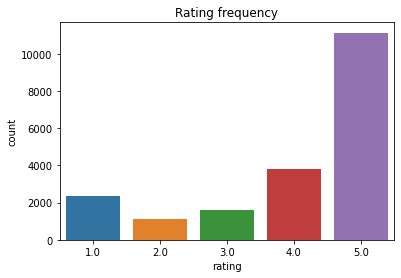

In [10]:
# Counting the number of ratings to see
sns.countplot(x='rating', data= sampled_data)
plt.title("Rating frequency")
plt.show()

<AxesSubplot:>

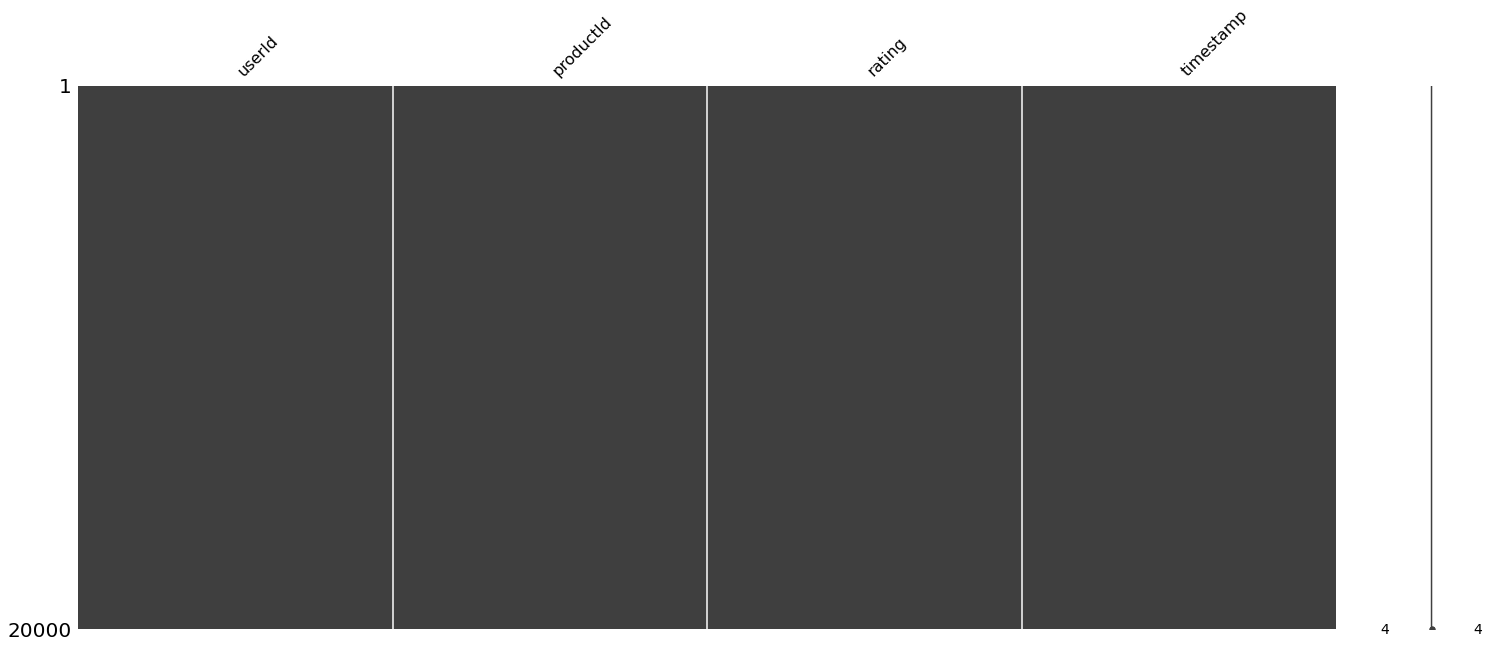

In [11]:
# Check for missing data 
msno.matrix(sampled_data)

NO missing data 

Convert the timestamp column from unix code to dd/mm/yyyy formar

In [13]:
data_by_date = data.copy()
data_by_date.timestamp = pd.to_datetime(data.timestamp, unit="s")#.dt.date
data_by_date = data_by_date.sort_values(by="timestamp", ascending=False).reset_index(drop=True)
data_by_date.groupby("timestamp")["rating"].count().tail(10).reset_index()


,timestamp,rating
0,2014-07-14,9701
1,2014-07-15,6892
2,2014-07-16,5943
3,2014-07-17,4781
4,2014-07-18,4912
5,2014-07-19,4183
6,2014-07-20,4273
7,2014-07-21,5458
8,2014-07-22,5010
9,2014-07-23,695


In [15]:
data_by_date["year"]  = data_by_date.timestamp.dt.year
data_by_date["month"] = data_by_date.timestamp.dt.month
list_of_years = data_by_date.year.unique()
list_of_years

array([2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004,
       2003, 2002, 2001, 2000, 1999, 1998], dtype=int64)

Group the data to see the number of rating each preoduct got.

In [12]:
data_product_grp = pd.DataFrame({"Number of Rating" : sampled_data.groupby('productId').count()['rating'], 
'Mean Rating': sampled_data.groupby('productId').mean()['rating']})

In [16]:
data_product_grp = data_product_grp.sort_values("Number of Rating", ascending=False)
data_product_grp



,Number of Rating,Mean Rating
productId,,
B00DR0PDNE,55,4.090909
B007WTAJTO,43,4.325581
B0074BW614,42,4.428571
B003ES5ZUU,32,4.781250
B003ELYQGG,32,4.437500
...,...,...
B002OOWI00,1,5.000000
B002OP0Z40,1,5.000000
B002OQ1J08,1,4.000000


## Creating Recommendation models

### First Model

We will use the Surprise framework. Surprise framework makes creating recoomendation systems easier as it is built with tools and fitted with pipelines that help in reccommendation systems

In [54]:
from surprise import accuracy
from surprise.model_selection.validation import cross_validate
from surprise.dataset import Dataset
from surprise.reader import Reader
from surprise import SVD
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import Trainset
reader =  Reader()

Create the data (suprise format)

In [38]:
surprise_data= Dataset.load_from_df(sampled_data[['userId','productId','rating']],reader)
surprise_data


Split the data into train and test sets

In [51]:
from surprise.model_selection import train_test_split

traindata,testdata = train_test_split(surprise_data,test_size=.3,random_state=10, shuffle = True)

Decided to use KNNwithmeans and do a gridsearch to find the best parameters for the baseline model

In [28]:
from surprise import Dataset
from surprise.model_selection import GridSearchCV

In [44]:
sim_options={
    "name":["msd","cosine", "pearson","pearson_baseline"],
    "min_support":[3,4,51],
    "user_based":[True],
}
params={'sim_options':sim_options}
gs = GridSearchCV(KNNWithMeans, params, measures=["rmse", "mae"], cv=3)
gs.fit(surprise_data)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix.

In [45]:
print('Best score:', gs.best_score["rmse"])
print("Best params: ", gs.best_params["rmse"])

Best score: 1.3846265595317646
Best params:  {'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': True}}


In [68]:
best_params = {
    
    "name":"msd",
    "min_support":3,
    "user_based":True,
}

knn_model = KNNWithMeans(k= 10, sim_options=best_params)
knn_model.fit(trainset= traindata)

Computing the msd similarity matrix...
Done computing similarity matrix.


For this model the RMSE loss was **1.3846**

### Second Model

We will use the **Singular Value Decomposition** algorithm to reduce the error

In [70]:
svd = SVD()
reader = Reader()
dataa = Dataset.load_from_df(sampled_data[['userId','productId','rating']], reader)


In [73]:
dataa

In [93]:
cross_val = cross_validate(svd, dataa, measures=['RMSE', 'MAE'], cv = 5, verbose=True)
cross_val

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3943  1.3657  1.3659  1.3777  1.3748  1.3757  0.0105  
MAE (testset)     1.1055  1.0851  1.0820  1.0948  1.0871  1.0909  0.0084  
Fit time          0.71    0.73    0.75    0.77    0.75    0.74    0.02    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([1.39429259, 1.36567024, 1.365945  , 1.37773751, 1.37483822]),
 'test_mae': array([1.10549408, 1.08508933, 1.08201052, 1.09484267, 1.08713869]),
 'fit_time': (0.7123095989227295,
  0.7256913185119629,
  0.75038743019104,
  0.7710747718811035,
  0.7454078197479248),
 'test_time': (0.01606464385986328,
  0.015535354614257812,
  0.017049074172973633,
  0.018024206161499023,
  0.01566600799560547)}

In [95]:
x = pd.DataFrame(cross_val)
x

,test_rmse,test_mae,fit_time,test_time
0,1.394293,1.105494,0.712310,0.016065
1,1.365670,1.085089,0.725691,0.015535
2,1.365945,1.082011,0.750387,0.017049
3,1.377738,1.094843,0.771075,0.018024
4,1.374838,1.087139,0.745408,0.015666


The RMSE of the SVD model is a bit higher than the baseline KNN model

In [75]:
trainset = dataa.build_full_trainset()

In [76]:
resultant_matrix = svd.fit(trainset)

In [79]:
data.head()

,userId,productId,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [77]:
data[data['userId'] == 'AKM1MP6P0OYPR'] 

,userId,productId,rating,timestamp
5200190,AKM1MP6P0OYPR,B005UEB5TQ,5.0,1366243200


In [80]:
svd.predict(uid='A1QGNMC6O1VW39',iid='0970407998',r_ui=None).est


4.0143

In [81]:
preds = svd.test(testdata)
preds

[Prediction(uid='A2RGA7UGAN3UL7', iid='B000V1R96Q', r_ui=5.0, est=4.308417438647141, details={'was_impossible': False}),
 Prediction(uid='A24PIDC1UKA9B2', iid='B00B7HLB1C', r_ui=5.0, est=4.4137668824916165, details={'was_impossible': False}),
 Prediction(uid='A32WS1SQTDYYO', iid='B008GW6OBI', r_ui=3.0, est=3.721967685890725, details={'was_impossible': False}),
 Prediction(uid='A3N9XE0T3JV1CL', iid='B000KL0XA6', r_ui=5.0, est=4.319069600647971, details={'was_impossible': False}),
 Prediction(uid='A2N9UKXEAPPF7M', iid='B000O6SI6S', r_ui=5.0, est=4.390996562861814, details={'was_impossible': False}),
 Prediction(uid='A2J3T0K9PPD7V', iid='B000XA2XJS', r_ui=5.0, est=4.334018560456471, details={'was_impossible': False}),
 Prediction(uid='AQ66QMEGV2FEI', iid='B004E8Z3KQ', r_ui=5.0, est=4.437885408853823, details={'was_impossible': False}),
 Prediction(uid='A1F0WKPVLAX48W', iid='B0042F3K9W', r_ui=5.0, est=4.392291968431695, details={'was_impossible': False}),
 Prediction(uid='A3EG50G1QFX2YH', 

Lets create a dataframe of the reulting predictions

In [84]:
resultss = pd.DataFrame(preds, columns=['userId', 'itemId', 'user_rating', 'model_estimate', 'details'])
resultss['err'] = abs (resultss.model_estimate - resultss.user_rating)

In [88]:
final_result = resultss.drop('details', 1)

C:\Users\USER\AppData\Local\Temp\ipykernel_4252\819725014.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  final_result = resultss.drop('details', 1)


In [89]:
final_result

,userId,itemId,user_rating,model_estimate,err
0,A2RGA7UGAN3UL7,B000V1R96Q,5.0,4.308417,0.691583
1,A24PIDC1UKA9B2,B00B7HLB1C,5.0,4.413767,0.586233
2,A32WS1SQTDYYO,B008GW6OBI,3.0,3.721968,0.721968
3,A3N9XE0T3JV1CL,B000KL0XA6,5.0,4.319070,0.680930
4,A2N9UKXEAPPF7M,B000O6SI6S,5.0,4.390997,0.609003
...,...,...,...,...,...
5995,AH24KOBRRGG7S,B003LR7ME6,5.0,4.549161,0.450839
5996,A3QSVYCOB9XJSZ,B000KL1U1W,4.0,3.980621,0.019379
5997,A3I6HYTU037QBA,B005HIS6II,5.0,4.494317,0.505683
5998,A3LFSJXZN6JQ8E,B002RL8H1Y,5.0,4.416261,0.583739


Finally with a good recommendation model we should save the SVD model 

In [90]:
import pickle

In [91]:
with open('recsyst_pkl', 'wb') as files:
    pickle.dump(svd, files)